DQN 算法敲开了**深度强化学习**的大门，但是作为先驱性的工作，其本身存在着一些问题以及一些可以改进的地方。于是，在 DQN 之后，学术界涌现出了非常多的改进算法。本章将介绍其中两个非常著名的算法：Double DQN 和 Dueling DQN

## Double DQN

为了解决传统DQN的Q值估计过大问题, 将更新误差目标分为两步, 即先用神经网络估计价值最大的动作, 再在此基础上用另一套神经网络计算该动作的价值, 从而缓冲了原来使用一步计算价值造成的误差累计

代码可以在DQN的基础上作出一些修改

Iteration 9: 100%|██████████| 20/20 [00:06<00:00,  3.28it/s, episodes=200, return=-141.038]


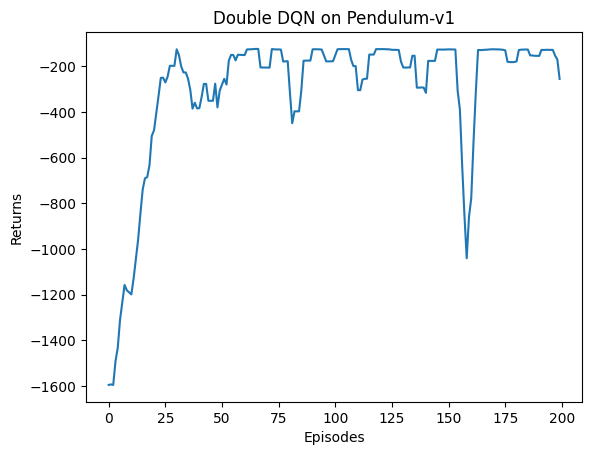

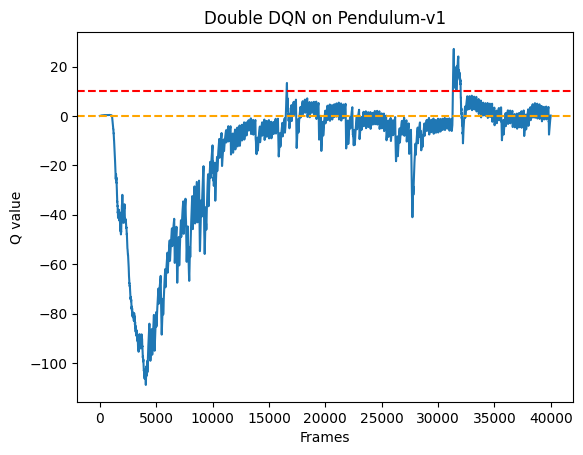

In [3]:
import random
import gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm

from rl_utils import ReplayBuffer


class Qnet(torch.nn.Module):
    """only oe hidden layer"""
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class DQN:
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type = 'VanillaDQN'):

        self.action_dim =action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr = learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1,1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1,1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1,1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)

        """the difference between DoubleDQN and DQN, while the former one gets the best action from
        q_net, and max_q_value from target_q_net, the later get max_q_vales all from target_Q_net"""

        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1,1)
            max_next_q_values = self.target_q_net(next_states).gather(1,max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1,1)

        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values,q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())

        self.count += 1



lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11
# DQN cant handle sequent action, while this env has a sequent action space,
# so we have to discrete it.
def dis_to_con(discrete_action, env, action_dim):
    action_lowbound = env.action_space.low[0]
    action_upbound = env.action_space.high[0]
    return action_lowbound + (discrete_action / (action_dim - 1)) * (action_upbound - action_lowbound)

def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total = int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset(seed = 0)[0]
                done = False
                steps = 0
                while not  done and steps <200:
                    action = agent.take_action(state)
                    steps += 1
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995
                    max_q_value_list.append(max_q_value)
                    action_continuous = dis_to_con(action, env, agent.action_dim)
                    next_state, reward, done, _, __ = env.step([action_continuous])
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episodes':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list


if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

random.seed(0)
np.random.seed(0)

torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, 'DoubleDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

frames_lsit = list(range(len(max_q_value_list)))
plt.plot(frames_lsit, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Double DQN on {}'.format(env_name))
plt.show()


Iteration 9: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s, episodes=200, return=-319.598]


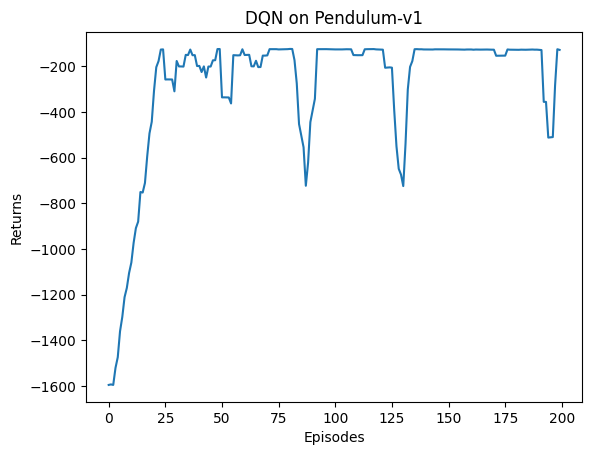

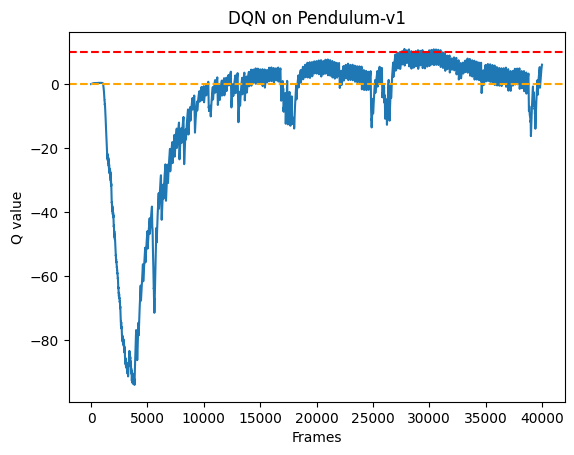

In [4]:
"""作为对比, 这里是DQN的代码"""

random.seed(0)
np.random.seed(0)
env.reset(seed = 0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

## Dual DQN

将动作价值函数分开建模(状态价值函数V和优势函数A), 使得智能体更关注动作

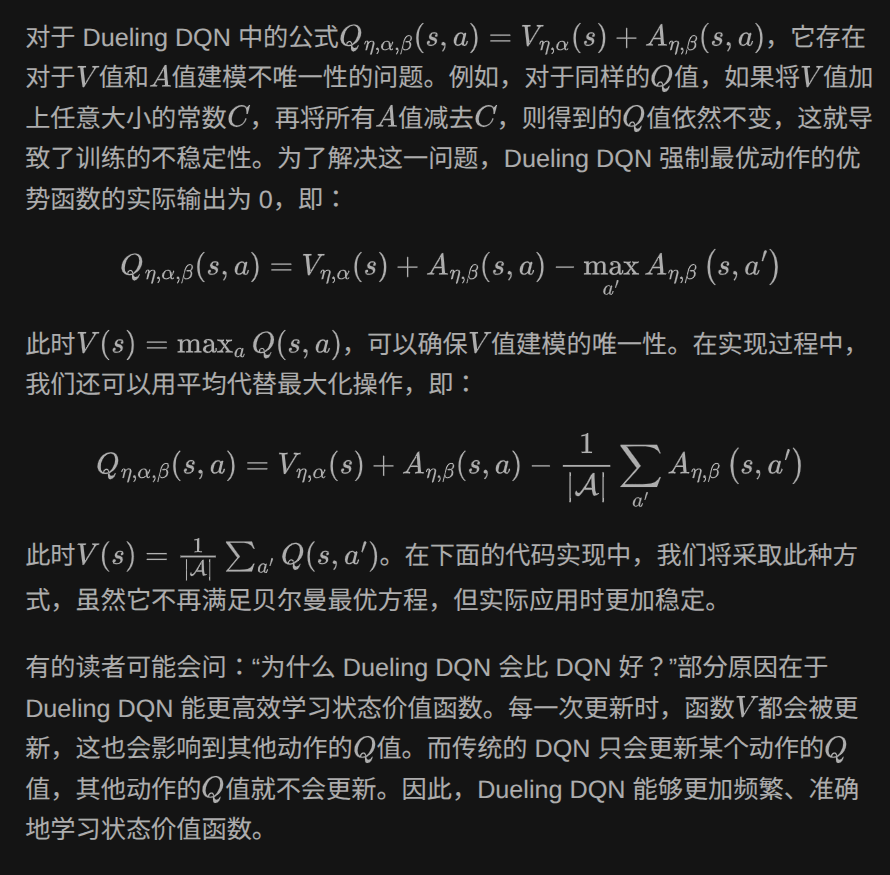

Iteration 9: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s, episode=200, return=-126.281]


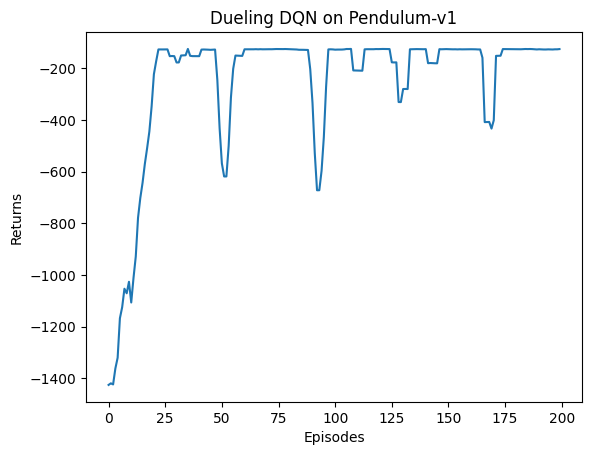

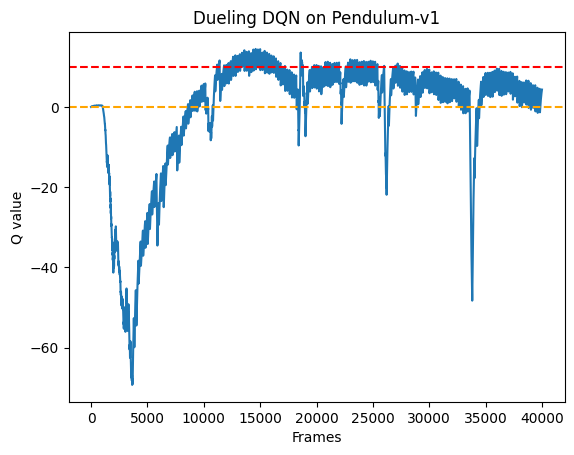

In [5]:
import random
import gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm


class Qnet(torch.nn.Module):
    """only oe hidden layer"""
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class VAnet(torch.nn.Module):
    """only one hiddden layer, A_net  and  V_net"""
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # sharing network
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1,1)   # Q consists of A, V
        return Q

class DQN:
    """DQN Algorithm, including DoubleDQN, DuelingDQN"""
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        if dqn_type == 'DuelingDQN': #DuelingDQN takes different network structure
            self.q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)

        else:
            self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.device = device
        self.dqn_type = dqn_type
        self.count = 0

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1,1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1,1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1,1).to(self.device)

        q_values = self.q_net(states).gather(1,actions)
        if self.dqn_type == 'DoubleDQN':
            max_actions = self.q_net(next_states).max(1)[1].view(-1,1)
            max_next_q_values = self.target_q_net(next_states).gather(1,max_actions)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1,1)

        q_targets = rewards + self.gamma * max_next_q_values * (1-dones)
        dqn_loss = torch.mean(F.mse_loss(q_values,q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())

        self.count += 1





lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11
# DQN cant handle sequent action, while this env has a sequent action space,
# so we have to discrete it.
def dis_to_con(discrete_action, env, action_dim):
    action_lowbound = env.action_space.low[0]
    action_upbound = env.action_space.high[0]
    return action_lowbound + (discrete_action / (action_dim - 1)) * (action_upbound - action_lowbound)

def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total = int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset(seed = 0)[0]
                done = False
                steps = 0
                while not  done and steps <200:
                    action = agent.take_action(state)
                    steps += 1
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995
                    max_q_value_list.append(max_q_value)
                    action_continuous = dis_to_con(action, env, agent.action_dim)
                    next_state, reward, done, _, __ = env.step([action_continuous])
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list

random.seed(30)
np.random.seed(30)

torch.manual_seed(30)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, 'DuelingDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

frames_lsit = list(range(len(max_q_value_list)))
plt.plot(frames_lsit, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()